# Imports

In [1]:
import json

import numpy as np
import pandas as pd
import seaborn as sns


In [2]:
%matplotlib inline

In [3]:
data_url = 'https://raw.githubusercontent.com/ksetdekov/test_predict_ts/main/2_5350833418869411277.csv'
data = pd.read_csv(data_url)
data

,date,clients
0,1/2/2010 0:00,129.0
1,1/2/2010 1:00,148.0
2,1/2/2010 2:00,159.0
3,1/2/2010 3:00,181.0
4,1/2/2010 4:00,138.0
...,...,...
43795,NaN,NaN
43796,NaN,NaN
43797,NaN,NaN
43798,NaN,NaN


In [4]:
data.tail(30)

,date,clients
43770,12/30/2014 18:00,79.0
43771,12/30/2014 19:00,35.0
43772,12/30/2014 20:00,26.0
43773,12/30/2014 21:00,20.0
43774,12/30/2014 22:00,8.0
43775,12/30/2014 23:00,16.0
43776,NaN,NaN
43777,NaN,NaN
43778,NaN,NaN
43779,NaN,NaN


In [5]:
data.date = pd.to_datetime(data.date)

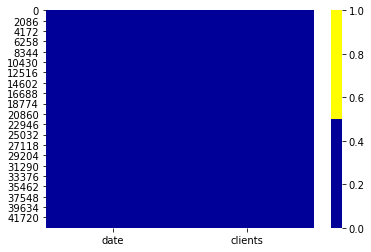

In [6]:
colors = ['#000099', '#ffff00'] 

a = sns.heatmap(data.isnull(), cmap=sns.color_palette(colors))

Визуально пропусков не подавляющее число

<AxesSubplot:>

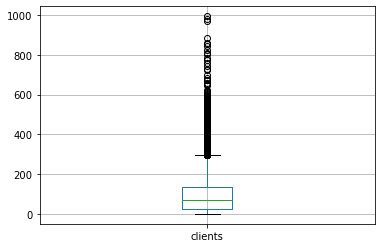

In [7]:
data.boxplot(column=['clients'])

In [8]:
data.describe()

,clients
count,43776.000000
mean,94.059553
std,92.256575
min,0.000000
25%,24.000000
50%,68.000000
75%,133.000000
max,994.000000


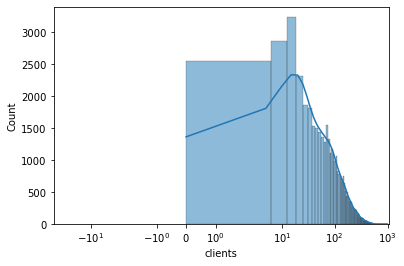

In [9]:
ax = sns.histplot(data=data, x="clients", kde=True)
ax.set_xscale('symlog')

<AxesSubplot:xlabel='clients', ylabel='Count'>

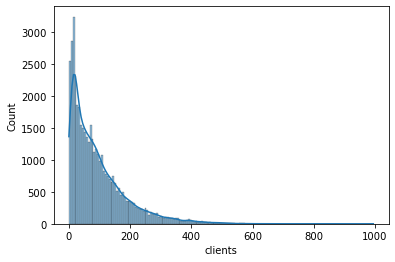

In [10]:
sns.histplot(data=data, x="clients", kde=True)

Целевая переменная с тяжелым правым хвостом, наблюдаемые значение имеют положительную ассиметрию, мода меньше среднего, все наблюдаемые значения $< 1000$.

In [11]:
misscount = data.isna().sum()
misscount[misscount>0]

date       24
clients    24
dtype: int64

Есть предположение, что 0 могуть быть пропусками, других пропусков, кроме хвоста датасета нет.

In [12]:
data = data.set_index('date')
data.dropna(inplace=True)

In [13]:
data.tail()

,clients
date,
2014-12-30 19:00:00,35.0
2014-12-30 20:00:00,26.0
2014-12-30 21:00:00,20.0
2014-12-30 22:00:00,8.0
2014-12-30 23:00:00,16.0


In [14]:
data.dtypes

clients    float64
dtype: object

In [15]:
import statsmodels.api as sm
import warnings
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

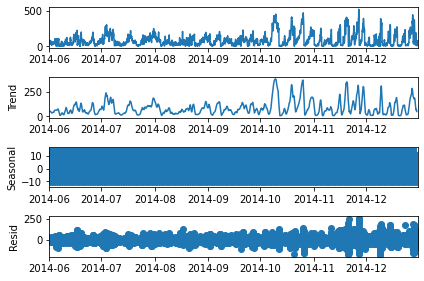

In [16]:
decompostition = sm.tsa.seasonal_decompose(data['2014-06-01':], model= 'additive')
fig = decompostition.plot()
matplotlib.rcParams['figure.figsize'] = [10, 6]

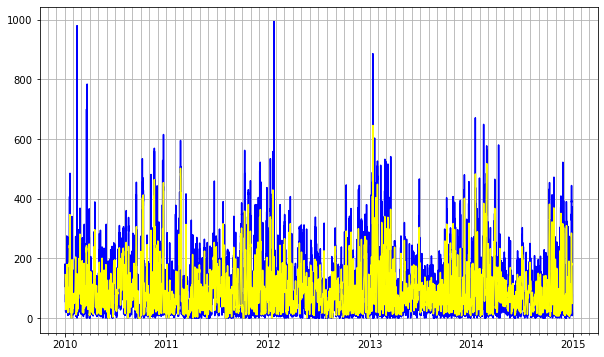

In [17]:
decompostition = sm.tsa.seasonal_decompose(data, model='additive')

fig, ax = plt.subplots()
ax.grid(True)

year = mdates.YearLocator(month=1)
month = mdates.MonthLocator(interval=1)

year_format = mdates.DateFormatter('%Y')
month_format = mdates.DateFormatter('%m')

ax.xaxis.set_minor_locator(month)
ax.xaxis.grid(True, which ='minor')
ax.xaxis.set_major_locator(year)
ax.xaxis.set_major_formatter(year_format)

plt.plot(data.index, data, c='blue')
plt.plot(decompostition.trend.index, decompostition.trend, c='yellow')

In [18]:
from pandas import Series
from sklearn.preprocessing import MinMaxScaler

#prep for norm
values = data.clients
values = np.array(values.tolist())
values = values.reshape((len(values), 1))

#train normalizer
scaler = MinMaxScaler(feature_range=(0,1))
scaler = scaler.fit(values)
print(f'Min: {scaler.data_min_}, max:{scaler.data_max_}')

Min: [0.], max:[994.]


## prep data

In [19]:
ts_data = data.copy()
ts_data['hour'] = [ts_data.index[i].hour for i in range(len(ts_data))]
ts_data['month'] = [ts_data.index[i].month for i in range(len(ts_data))]
ts_data['weekday'] = [ts_data.index[i].day for i in range(len(ts_data))]
ts_data['last_day_m'] = [ts_data.index[i].is_month_end for i in range(len(ts_data))]
ts_data['last_day_m']=ts_data['last_day_m'].astype(int)
ts_data.head()

,clients,hour,month,weekday,last_day_m
date,,,,,
2010-01-02 00:00:00,129.0,0,1,2,0
2010-01-02 01:00:00,148.0,1,1,2,0
2010-01-02 02:00:00,159.0,2,1,2,0
2010-01-02 03:00:00,181.0,3,1,2,0
2010-01-02 04:00:00,138.0,4,1,2,0


### sliding window stats

In [20]:
def generate_lagged_features(ts_data, var, max_lag):
    for t in range(1, max_lag+1):
        ts_data[var+'_l'+str(t)] = ts_data[var].shift(t, freq='1H')

In [21]:
generate_lagged_features(ts_data, 'clients', 48)

In [22]:
ts_data.tail()

,clients,hour,month,weekday,last_day_m,clients_l1,clients_l2,clients_l3,clients_l4,clients_l5,...,clients_l39,clients_l40,clients_l41,clients_l42,clients_l43,clients_l44,clients_l45,clients_l46,clients_l47,clients_l48
date,,,,,,,,,,,,,,,,,,,,,
2014-12-30 19:00:00,35.0,19,12,30,0,79.0,63.0,60.0,55.0,65.0,...,318.0,372.0,373.0,372.0,362.0,341.0,324.0,293.0,175.0,110.0
2014-12-30 20:00:00,26.0,20,12,30,0,35.0,79.0,63.0,60.0,55.0,...,188.0,318.0,372.0,373.0,372.0,362.0,341.0,324.0,293.0,175.0
2014-12-30 21:00:00,20.0,21,12,30,0,26.0,35.0,79.0,63.0,60.0,...,171.0,188.0,318.0,372.0,373.0,372.0,362.0,341.0,324.0,293.0
2014-12-30 22:00:00,8.0,22,12,30,0,20.0,26.0,35.0,79.0,63.0,...,136.0,171.0,188.0,318.0,372.0,373.0,372.0,362.0,341.0,324.0
2014-12-30 23:00:00,16.0,23,12,30,0,8.0,20.0,26.0,35.0,79.0,...,124.0,136.0,171.0,188.0,318.0,372.0,373.0,372.0,362.0,341.0


### rolling window stats

In [23]:
from pandas import concat

clients_val = ts_data[["clients"]]
width = 24
shifted = clients_val.shift(width -1)
window = shifted.rolling(window=width)

new_df = pd.concat([window.min(), window.mean(), window.max()], axis=1)
new_df.columns = ['min24', 'mean24', 'max24']


width=48
shifted = clients_val.shift(width -1)
window = shifted.rolling(window=width)

new_df_2 = pd.concat([window.min(), window.mean(), window.max()], axis=1)
new_df_2.columns = ['min48', 'mean48', 'max48']

new_df_2= pd.merge(new_df_2, new_df, how='outer', on="date")
ts_data = pd.merge(ts_data, new_df_2, how='outer', on="date")
ts_data.tail()

,clients,hour,month,weekday,last_day_m,clients_l1,clients_l2,clients_l3,clients_l4,clients_l5,...,clients_l45,clients_l46,clients_l47,clients_l48,min48,mean48,max48,min24,mean24,max24
date,,,,,,,,,,,,,,,,,,,,,
2014-12-30 19:00:00,35.0,19,12,30,0,79.0,63.0,60.0,55.0,65.0,...,324.0,293.0,175.0,110.0,32.0,211.520833,444.0,20.0,180.125000,373.0
2014-12-30 20:00:00,26.0,20,12,30,0,35.0,79.0,63.0,60.0,55.0,...,341.0,324.0,293.0,175.0,32.0,212.583333,444.0,20.0,173.250000,373.0
2014-12-30 21:00:00,20.0,21,12,30,0,26.0,35.0,79.0,63.0,60.0,...,362.0,341.0,324.0,293.0,32.0,214.958333,444.0,20.0,166.583333,373.0
2014-12-30 22:00:00,8.0,22,12,30,0,20.0,26.0,35.0,79.0,63.0,...,372.0,362.0,341.0,324.0,32.0,218.020833,444.0,20.0,159.000000,373.0
2014-12-30 23:00:00,16.0,23,12,30,0,8.0,20.0,26.0,35.0,79.0,...,373.0,372.0,362.0,341.0,32.0,222.166667,444.0,20.0,151.791667,373.0


In [24]:
from pandas.plotting import lag_plot

<AxesSubplot:xlabel='y(t)', ylabel='y(t + 1)'>

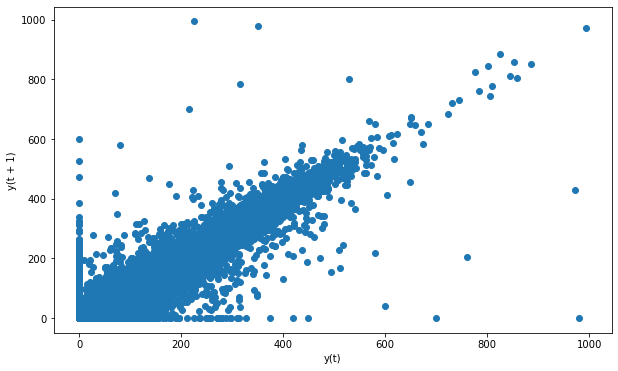

In [25]:
plt.figure()
lag_plot(ts_data.clients)

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

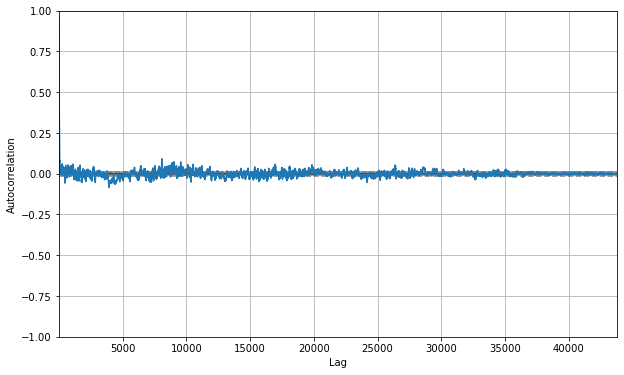

In [26]:
from pandas.plotting import autocorrelation_plot
plt.figure()
autocorrelation_plot(ts_data.clients)

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

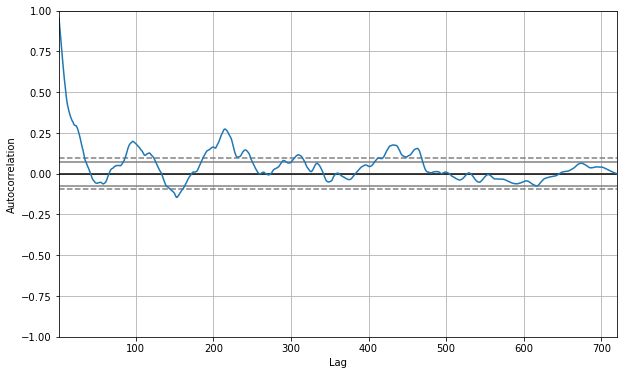

In [27]:
ts_data_subset = ts_data['2014-12-01':]
autocorrelation_plot(ts_data_subset)

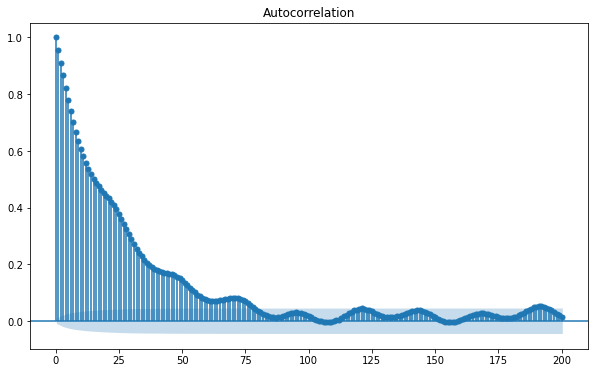

In [28]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(ts_data.clients, lags=200)
plt.show()

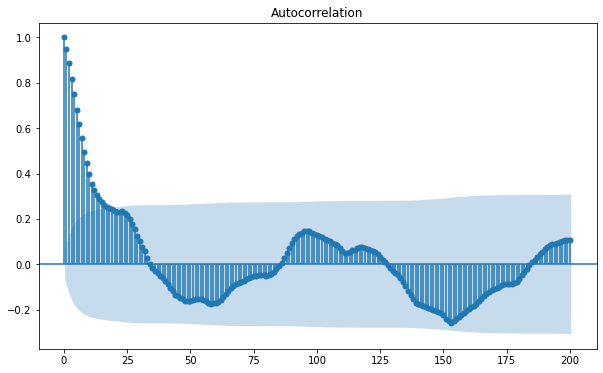

In [29]:
plot_acf(ts_data_subset.clients, lags=200)
plt.show()

есть основания смотреть на лаги порядка 20-80

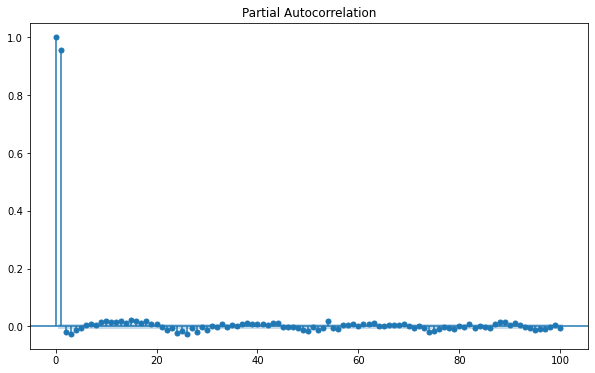

In [30]:
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(ts_data.clients, lags=100)
plt.show()

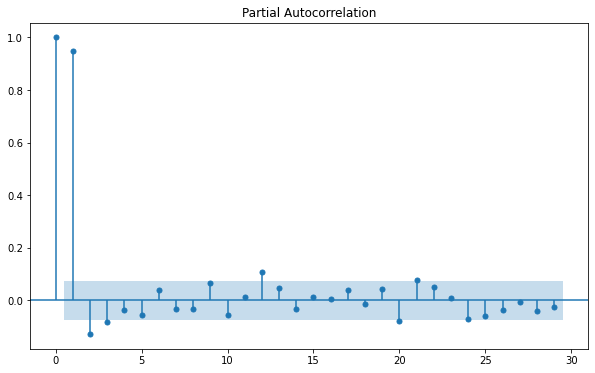

In [31]:
plot_pacf(ts_data_subset.clients)
plt.show()

# AR
## выводы по данным ACF и  PACF
Однозначно стоит брать лаги до 4, но если смотреть на все данные - есть основания смотреть лаги до 80-го

In [32]:
%matplotlib inline
from statsmodels.tsa.ar_model import AutoReg, ar_select_order
from statsmodels.tsa.api import acf, pacf, graphics
#AR model
model = AutoReg(ts_data.clients,  80)
results = model.fit()
results.summary()

C:\Users\ksetd\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
C:\Users\ksetd\Anaconda3\lib\site-packages\statsmodels\tsa\ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(


<class 'statsmodels.iolib.summary.Summary'>
"""
                            AutoReg Model Results                             
==============================================================================
Dep. Variable:                clients   No. Observations:                43776
Model:                    AutoReg(80)   Log Likelihood             -206260.731
Method:               Conditional MLE   S.D. of innovations             27.151
Date:                Mon, 14 Jun 2021   AIC                              6.607
Time:                        13:40:39   BIC                              6.623
Sample:                    01-05-2010   HQIC                             6.612
                         - 12-30-2014                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
intercept       4.1167      0.252     16.307      0.000       3.622       4.612
clients.L1      0.9682      0.005    202.384      0.000       0.959       0.978
clients.L2      0.0049      0.007      0.737      0.461      -0.008       0.018
clients.L3     -0.0112      0.007     -1.686      0.092      -0.024       0.002
clients.L4     -0.0061      0.007     -0.915      0.360      -0.019       0.007
clients.L5     -0.0089      0.007     -1.340      0.180      -0.022       0.004
clients.L6     -0.0030      0.007     -0.457      0.648      -0.016       0.010
clients.L7      0.0043      0.007      0.641      0.521      -0.009       0.017
clients.L8     -0.0073      0.007     -1.102      0.270      -0.020       0.006
clients.L9     -0.0020      0.007     -0.297      0.766      -0.015       0.011
clients.L10     0.0056      0.007      0.839      0.401      -0.007       0.019
clients.L11     0.0006      0.007      0.089      0.929      -0.012       0.014
clients.L12    -0.0023      0.007     -0.353      0.724      -0.015       0.011
clients.L13     0.0091      0.007      1.368      0.171      -0.004       0.022
clients.L14    -0.0098      0.007     -1.469      0.142      -0.023       0.003
clients.L15     0.0034      0.007      0.507      0.612      -0.010       0.016
clients.L16     0.0072      0.007      1.085      0.278      -0.006       0.020
clients.L17    -0.0089      0.007     -1.342      0.180      -0.022       0.004
clients.L18     0.0120      0.007      1.806      0.071      -0.001       0.025
clients.L19    -0.0010      0.007     -0.157      0.875      -0.014       0.012
clients.L20     0.0094      0.007      1.408      0.159      -0.004       0.022
clients.L21     0.0091      0.007      1.372      0.170      -0.004       0.022
clients.L22    -0.0109      0.007     -1.638      0.101      -0.024       0.002
clients.L23     0.0164      0.007      2.457      0.014       0.003       0.029
clients.L24    -0.0075      0.007     -1.126      0.260      -0.021       0.006
clients.L25     0.0094      0.007      1.412      0.158      -0.004       0.022
clients.L26    -0.0208      0.007     -3.127      0.002      -0.034      -0.008
clients.L27     0.0120      0.007      1.805      0.071      -0.001       0.025
clients.L28    -0.0154      0.007     -2.310      0.021      -0.028      -0.002
clients.L29     0.0087      0.007      1.304      0.192      -0.004       0.022
clients.L30    -0.0122      0.007     -1.832      0.067      -0.025       0.001
clients.L31     0.0052      0.007      0.786      0.432      -0.008       0.018
clients.L32    -0.0098      0.007     -1.470      0.142      -0.023       0.003
clients.L33     0.0108      0.007      1.627      0.104      -0.002       0.024
clients.L34    -0.0057      0.007     -0.862      0.389      -0.019       0.007
clients.L35     0.0022      0.007      0.327      0.744      -0.011       0.015
clients.L36    -0.0063      0.007     -0.946      0.344      -0.019       0.007
clients.L37    -0.0008      0.007     -0.

In [33]:
res = model.fit(cov_type='HC0')
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            AutoReg Model Results                             
==============================================================================
Dep. Variable:                clients   No. Observations:                43776
Model:                    AutoReg(80)   Log Likelihood             -206260.731
Method:               Conditional MLE   S.D. of innovations             27.151
Date:                Mon, 14 Jun 2021   AIC                              6.607
Time:                        13:40:39   BIC                              6.623
Sample:                    01-05-2010   HQIC                             6.612
                         - 12-30-2014                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
intercept       4.1167      0.295     13.974      0.000       3.539       4.694
clients.L1      0.9682      0.034     28.447      0.000       0.901       1.035
clients.L2      0.0049      0.050      0.099      0.921      -0.092       0.102
clients.L3     -0.0112      0.037     -0.306      0.760      -0.083       0.061
clients.L4     -0.0061      0.018     -0.339      0.735      -0.041       0.029
clients.L5     -0.0089      0.011     -0.795      0.427      -0.031       0.013
clients.L6     -0.0030      0.012     -0.265      0.791      -0.026       0.020
clients.L7      0.0043      0.010      0.428      0.669      -0.015       0.024
clients.L8     -0.0073      0.010     -0.702      0.483      -0.028       0.013
clients.L9     -0.0020      0.009     -0.222      0.824      -0.019       0.015
clients.L10     0.0056      0.008      0.730      0.465      -0.009       0.021
clients.L11     0.0006      0.008      0.077      0.939      -0.015       0.016
clients.L12    -0.0023      0.008     -0.288      0.773      -0.018       0.014
clients.L13     0.0091      0.009      0.997      0.319      -0.009       0.027
clients.L14    -0.0098      0.008     -1.227      0.220      -0.025       0.006
clients.L15     0.0034      0.007      0.476      0.634      -0.011       0.017
clients.L16     0.0072      0.007      0.983      0.326      -0.007       0.022
clients.L17    -0.0089      0.008     -1.161      0.246      -0.024       0.006
clients.L18     0.0120      0.008      1.511      0.131      -0.004       0.028
clients.L19    -0.0010      0.008     -0.133      0.894      -0.016       0.014
clients.L20     0.0094      0.008      1.152      0.249      -0.007       0.025
clients.L21     0.0091      0.008      1.189      0.234      -0.006       0.024
clients.L22    -0.0109      0.008     -1.424      0.154      -0.026       0.004
clients.L23     0.0164      0.008      2.120      0.034       0.001       0.031
clients.L24    -0.0075      0.008     -0.890      0.373      -0.024       0.009
clients.L25     0.0094      0.009      1.062      0.288      -0.008       0.027
clients.L26    -0.0208      0.008     -2.479      0.013      -0.037      -0.004
clients.L27     0.0120      0.007      1.654      0.098      -0.002       0.026
clients.L28    -0.0154      0.008     -1.958      0.050      -0.031    1.18e-05
clients.L29     0.0087      0.010      0.873      0.383      -0.011       0.028
clients.L30    -0.0122      0.009     -1.308      0.191      -0.030       0.006
clients.L31     0.0052      0.008      0.686      0.492      -0.010       0.020
clients.L32    -0.0098      0.008     -1.270      0.204      -0.025       0.005
clients.L33     0.0108      0.008      1.356      0.175      -0.005       0.026
clients.L34    -0.0057      0.007     -0.768      0.442      -0.020       0.009
clients.L35     0.0022      0.007      0.330      0.742      -0.011       0.015
clients.L36    -0.0063      0.006     -0.980      0.327      -0.019       0.006
clients.L37    -0.0008      0.006     -0.

C:\Users\ksetd\Anaconda3\lib\site-packages\statsmodels\tsa\deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


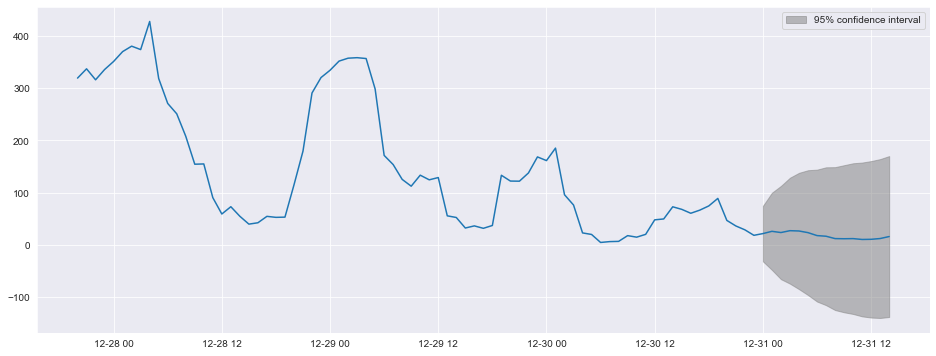

In [34]:
sns.set_style('darkgrid')
pd.plotting.register_matplotlib_converters()

sns.mpl.rc('figure', figsize=(16, 6))
figure = results.plot_predict(43700, 43790)

In [35]:
ts_data.shape

(43776, 59)

C:\Users\ksetd\Anaconda3\lib\site-packages\statsmodels\graphics\gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


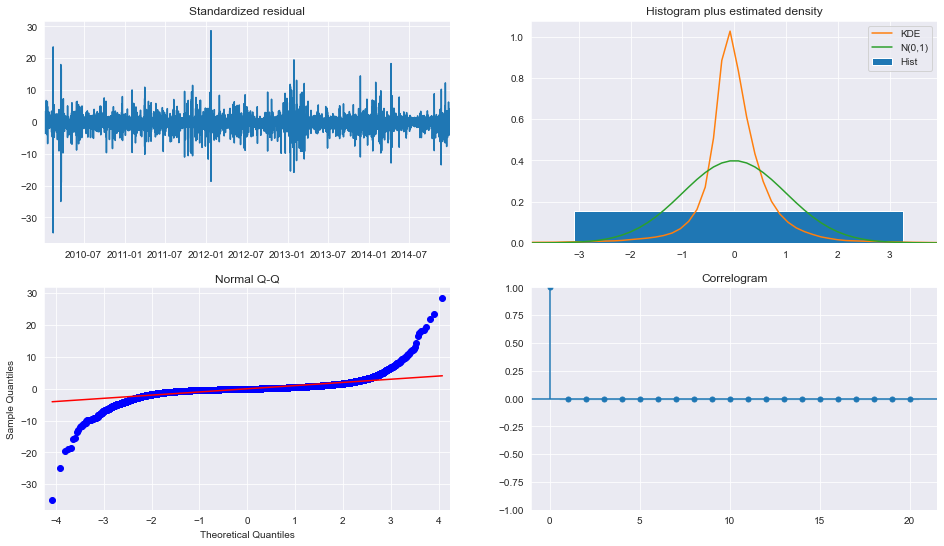

In [36]:
fig = plt.figure(figsize=(16,9))
fig = results.plot_diagnostics(fig=fig, lags = 20)

C:\Users\ksetd\Anaconda3\lib\site-packages\statsmodels\tsa\deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


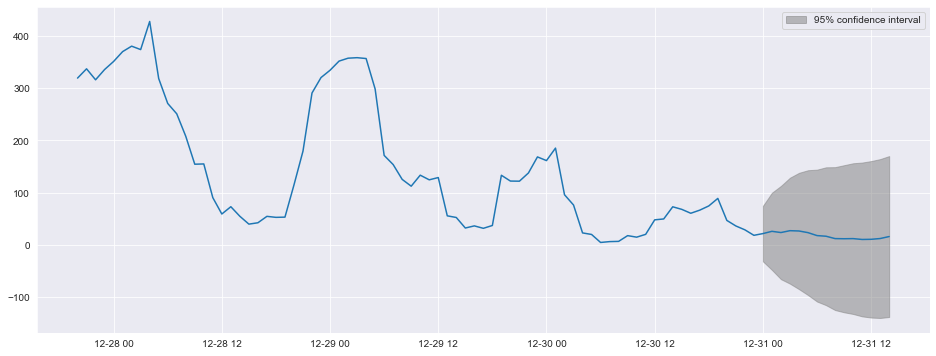

In [37]:
figure = res.plot_predict(43700, 43790)

In [38]:
ts_data.columns

Index(['clients', 'hour', 'month', 'weekday', 'last_day_m', 'clients_l1',
       'clients_l2', 'clients_l3', 'clients_l4', 'clients_l5', 'clients_l6',
       'clients_l7', 'clients_l8', 'clients_l9', 'clients_l10', 'clients_l11',
       'clients_l12', 'clients_l13', 'clients_l14', 'clients_l15',
       'clients_l16', 'clients_l17', 'clients_l18', 'clients_l19',
       'clients_l20', 'clients_l21', 'clients_l22', 'clients_l23',
       'clients_l24', 'clients_l25', 'clients_l26', 'clients_l27',
       'clients_l28', 'clients_l29', 'clients_l30', 'clients_l31',
       'clients_l32', 'clients_l33', 'clients_l34', 'clients_l35',
       'clients_l36', 'clients_l37', 'clients_l38', 'clients_l39',
       'clients_l40', 'clients_l41', 'clients_l42', 'clients_l43',
       'clients_l44', 'clients_l45', 'clients_l46', 'clients_l47',
       'clients_l48', 'min48', 'mean48', 'max48', 'min24', 'mean24', 'max24'],
      dtype='object')

In [39]:
without_na_ts_data = ts_data.dropna()
model_with_ex = AutoReg(without_na_ts_data.clients,  80, exog=without_na_ts_data[['hour', 'month', 'weekday', 'last_day_m', 'min48', 'mean48', 'max48', 'min24', 'mean24', 'max24']])
results_arex = model_with_ex.fit()
results_arex.summary()

C:\Users\ksetd\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
C:\Users\ksetd\Anaconda3\lib\site-packages\statsmodels\tsa\ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(


<class 'statsmodels.iolib.summary.Summary'>
"""
                            AutoReg Model Results                             
==============================================================================
Dep. Variable:                clients   No. Observations:                43682
Model:                  AutoReg-X(80)   Log Likelihood             -205774.363
Method:               Conditional MLE   S.D. of innovations             27.125
Date:                Mon, 14 Jun 2021   AIC                              6.605
Time:                        13:40:42   BIC                              6.623
Sample:                    01-09-2010   HQIC                             6.611
                         - 12-30-2014                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
intercept       1.3991      0.503      2.784      0.005       0.414       2.384
clients.L1      0.9663      0.005    201.787      0.000       0.957       0.976
clients.L2      0.0049      0.007      0.738      0.460      -0.008       0.018
clients.L3     -0.0106      0.007     -1.599      0.110      -0.024       0.002
clients.L4     -0.0049      0.007     -0.739      0.460      -0.018       0.008
clients.L5     -0.0079      0.007     -1.182      0.237      -0.021       0.005
clients.L6     -0.0021      0.007     -0.318      0.751      -0.015       0.011
clients.L7      0.0044      0.007      0.661      0.509      -0.009       0.017
clients.L8     -0.0076      0.007     -1.136      0.256      -0.021       0.005
clients.L9     -0.0020      0.007     -0.298      0.766      -0.015       0.011
clients.L10     0.0048      0.007      0.722      0.470      -0.008       0.018
clients.L11     0.0002      0.007      0.028      0.978      -0.013       0.013
clients.L12    -0.0022      0.007     -0.327      0.744      -0.015       0.011
clients.L13     0.0083      0.007      1.245      0.213      -0.005       0.021
clients.L14    -0.0102      0.007     -1.528      0.126      -0.023       0.003
clients.L15     0.0036      0.007      0.546      0.585      -0.009       0.017
clients.L16     0.0074      0.007      1.110      0.267      -0.006       0.020
clients.L17    -0.0088      0.007     -1.328      0.184      -0.022       0.004
clients.L18     0.0116      0.007      1.743      0.081      -0.001       0.025
clients.L19    -0.0017      0.007     -0.258      0.797      -0.015       0.011
clients.L20     0.0090      0.007      1.353      0.176      -0.004       0.022
clients.L21     0.0086      0.007      1.296      0.195      -0.004       0.022
clients.L22    -0.0115      0.007     -1.729      0.084      -0.025       0.002
clients.L23     0.0170      0.007      2.531      0.011       0.004       0.030
clients.L24    -0.0071      0.007     -1.065      0.287      -0.020       0.006
clients.L25     0.0091      0.007      1.372      0.170      -0.004       0.022
clients.L26    -0.0203      0.007     -3.053      0.002      -0.033      -0.007
clients.L27     0.0124      0.007      1.866      0.062      -0.001       0.025
clients.L28    -0.0140      0.007     -2.098      0.036      -0.027      -0.001
clients.L29     0.0094      0.007      1.412      0.158      -0.004       0.022
clients.L30    -0.0114      0.007     -1.715      0.086      -0.024       0.002
clients.L31     0.0058      0.007      0.869      0.385      -0.007       0.019
clients.L32    -0.0101      0.007     -1.515      0.130      -0.023       0.003
clients.L33     0.0109      0.007      1.638      0.101      -0.002       0.024
clients.L34    -0.0062      0.007     -0.927      0.354      -0.019       0.007
clients.L35     0.0021      0.007      0.315      0.753      -0.011       0.015
clients.L36    -0.0067      0.007     -1.006      0.315      -0.020       0.006
clients.L37    -0.0010      0.007     -0.

C:\Users\ksetd\Anaconda3\lib\site-packages\statsmodels\graphics\gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


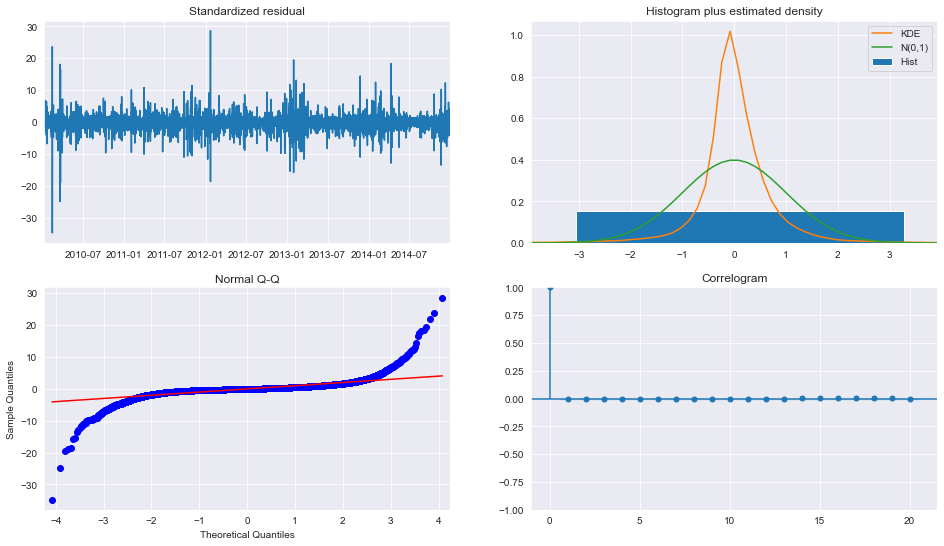

In [40]:
fig = plt.figure(figsize=(16,9))
fig = results_arex.plot_diagnostics(fig=fig, lags = 20)

In [41]:
without_na_ts_data.shape[0]

43682

In [42]:
pd.date_range(start='2014-12-31 00:00:00', end='2014-12-31 23:00:00', periods=24)
df_repeated = pd.concat([without_na_ts_data[['hour', 'month', 'weekday', 'last_day_m', 'min48', 'mean48', 'max48', 'min24', 'mean24', 'max24']]['2014-12-30 23:00':]]*24, ignore_index=True)
df_repeated = df_repeated.set_index(pd.date_range(start='2014-12-31 00:00:00', end='2014-12-31 23:00:00', periods=24))
df_repeated['hour'] = [df_repeated.index[i].hour for i in range(len(df_repeated))]
df_repeated['month'] = [df_repeated.index[i].month for i in range(len(df_repeated))]
df_repeated['weekday'] = [df_repeated.index[i].day for i in range(len(df_repeated))]
df_repeated['last_day_m'] = [df_repeated.index[i].is_month_end for i in range(len(df_repeated))]
df_repeated['last_day_m']=df_repeated['last_day_m'].astype(int)
df_repeated


,hour,month,weekday,last_day_m,min48,mean48,max48,min24,mean24,max24
2014-12-31 00:00:00,0,12,31,1,32.0,222.166667,444.0,20.0,151.791667,373.0
2014-12-31 01:00:00,1,12,31,1,32.0,222.166667,444.0,20.0,151.791667,373.0
2014-12-31 02:00:00,2,12,31,1,32.0,222.166667,444.0,20.0,151.791667,373.0
2014-12-31 03:00:00,3,12,31,1,32.0,222.166667,444.0,20.0,151.791667,373.0
2014-12-31 04:00:00,4,12,31,1,32.0,222.166667,444.0,20.0,151.791667,373.0
2014-12-31 05:00:00,5,12,31,1,32.0,222.166667,444.0,20.0,151.791667,373.0
2014-12-31 06:00:00,6,12,31,1,32.0,222.166667,444.0,20.0,151.791667,373.0
2014-12-31 07:00:00,7,12,31,1,32.0,222.166667,444.0,20.0,151.791667,373.0
2014-12-31 08:00:00,8,12,31,1,32.0,222.166667,444.0,20.0,151.791667,373.0
2014-12-31 09:00:00,9,12,31,1,32.0,222.166667,444.0,20.0,151.791667,373.0


In [43]:
without_na_ts_data = without_na_ts_data.asfreq('H')


### AR model CV


## реузультат RMSE 20.81089 на CV

In [44]:
from sklearn.model_selection import TimeSeriesSplit, cross_validate
from sklearn.metrics import mean_squared_error

tscv = TimeSeriesSplit(n_splits=100, test_size=24)
print(tscv)
rmse_cv_ar=[]
for train_index, test_index in tscv.split(without_na_ts_data):
    results_arex = model_with_ex.fit()
    model_with_ex_cv = AutoReg(without_na_ts_data.clients[train_index],  80, exog=without_na_ts_data[['hour', 'month', 'weekday', 'last_day_m', 'min48', 'mean48', 'max48', 'min24', 'mean24', 'max24']].iloc[train_index], old_names=False)
    results_arex_cv = model_with_ex.fit()
    y_hat = results_arex_cv.predict(without_na_ts_data.clients[train_index].shape[0],without_na_ts_data.clients[train_index].shape[0]+23, exog_oos = without_na_ts_data[['hour', 'month', 'weekday', 'last_day_m', 'min48', 'mean48', 'max48', 'min24', 'mean24', 'max24']].iloc[test_index])
    esimate_q = mean_squared_error(without_na_ts_data.clients[test_index], y_hat, squared=False)
    rmse_cv_ar.append(esimate_q)

print(f'RMSE on CV for AR + ex, average for 24 hours forward = {np.mean(rmse_cv_ar):.5f}')



TimeSeriesSplit(gap=0, max_train_size=None, n_splits=100, test_size=24)
RMSE on CV for AR + ex, average for 24 hours forward = 20.81089


C:\Users\ksetd\Anaconda3\lib\site-packages\statsmodels\tsa\deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


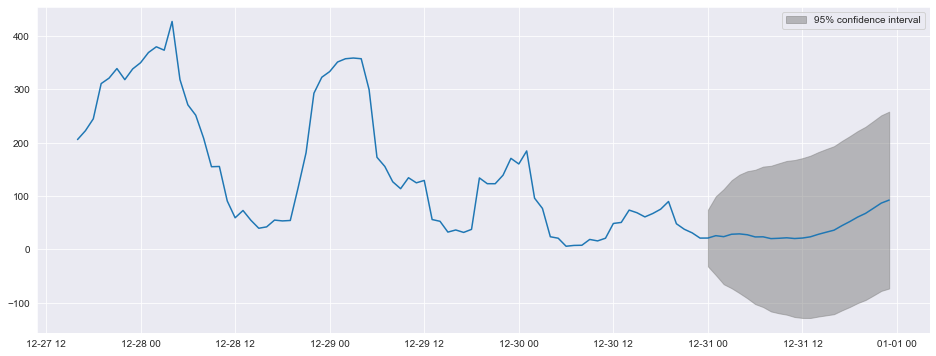

In [45]:
figure = results_arex.plot_predict(without_na_ts_data.shape[0]-80, without_na_ts_data.shape[0]+23, exog_oos=df_repeated)

In [46]:
fin_pred_ar = results_arex.predict(without_na_ts_data.shape[0],without_na_ts_data.shape[0]+23, exog_oos=df_repeated)
fin_pred_ar = pd.DataFrame(fin_pred_ar, columns=['yhat'])
fin_pred_ar['ds'] = fin_pred_ar.index
fin_pred_ar = fin_pred_ar[['ds', 'yhat']]
fin_pred_ar.to_csv('ar_predict.csv', index=False)

fin_pred_ar

,ds,yhat
2014-12-31 00:00:00,2014-12-31 00:00:00,21.002229
2014-12-31 01:00:00,2014-12-31 01:00:00,25.440496
2014-12-31 02:00:00,2014-12-31 02:00:00,23.600672
2014-12-31 03:00:00,2014-12-31 03:00:00,28.151366
2014-12-31 04:00:00,2014-12-31 04:00:00,28.827223
2014-12-31 05:00:00,2014-12-31 05:00:00,27.176322
2014-12-31 06:00:00,2014-12-31 06:00:00,23.087740
2014-12-31 07:00:00,2014-12-31 07:00:00,23.314280
2014-12-31 08:00:00,2014-12-31 08:00:00,19.949269
2014-12-31 09:00:00,2014-12-31 09:00:00,20.558059


# Random forest

## реузультат RMSE 20.64161 на CV

In [47]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV


In [48]:
tscv = TimeSeriesSplit(n_splits=5, test_size=24)

data_split = tscv.split(without_na_ts_data)
    
rnd_reg = RandomForestRegressor( )

# hyper-parameter space
param_grid_RF = {
    'n_estimators' : [10,20,50,100,200,500,1000],
    'max_features' : [0.6,0.8,"auto","sqrt"],
}
# gridsearch for the best hyper-parameter within the pipeline.
gs_rf = GridSearchCV(rnd_reg, param_grid=param_grid_RF, cv=data_split, n_jobs=-1,   return_train_score=True, verbose=2)
# fit dataset
gs_rf.fit(without_na_ts_data.loc[:, without_na_ts_data.columns != 'clients']
, without_na_ts_data.clients)

Fitting 5 folds for each of 28 candidates, totalling 140 fits


GridSearchCV(cv=<generator object TimeSeriesSplit.split at 0x000001549D018F90>,
             estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'max_features': [0.6, 0.8, 'auto', 'sqrt'],
                         'n_estimators': [10, 20, 50, 100, 200, 500, 1000]},
             return_train_score=True, verbose=2)

In [49]:
gs_rf.best_estimator_

RandomForestRegressor(max_features=0.8, n_estimators=50)

Лучшие параметры - max_features=0.8, n_estimators=50)


In [56]:
rf_reg_opt = RandomForestRegressor(max_features=0.8, n_estimators=50, bootstrap=True, oob_score=True)
rf_reg_opt.fit(without_na_ts_data.loc[:, without_na_ts_data.columns != 'clients']
, without_na_ts_data.clients)

RandomForestRegressor(max_features=0.8, n_estimators=50, oob_score=True)

In [57]:
for name, score in zip(without_na_ts_data.columns[1:], rf_reg_opt.feature_importances_):
    print(name, score)

hour 0.0024031967803578775
month 0.0013053388499564731
weekday 0.001880397698815554
last_day_m 0.0001323057150121775
clients_l1 0.7503840278645275
clients_l2 0.13267892689143782
clients_l3 0.04067996589178341
clients_l4 0.013239238122801254
clients_l5 0.0022311312159791156
clients_l6 0.0018107923735149857
clients_l7 0.0014456700525939626
clients_l8 0.001355250717463254
clients_l9 0.0015931276053547832
clients_l10 0.0012655029691616216
clients_l11 0.0013362974530325253
clients_l12 0.0012654532877019351
clients_l13 0.001428876351957309
clients_l14 0.0010240473726933796
clients_l15 0.0012611639397653634
clients_l16 0.0012241119385253464
clients_l17 0.0013517545436628076
clients_l18 0.0013696871296389763
clients_l19 0.001145352570413984
clients_l20 0.0011682744720041315
clients_l21 0.0011176143282503772
clients_l22 0.0009812860998975872
clients_l23 0.0010051762939324914
clients_l24 0.0009196040674101142
clients_l25 0.000966305116461755
clients_l26 0.0009493055474384075
clients_l27 0.000973

In [60]:
rf_reg_opt.oob_prediction_

array([145.15384615,  57.22727273,  47.63157895, ...,  34.82352941,
        25.1875    ,  14.65      ])

In [61]:
rf_reg_opt.oob_prediction_.shape

(43682,)

#### валидаяия oob

In [63]:
rmse_oob_rf = mean_squared_error(without_na_ts_data.clients, rf_reg_opt.oob_prediction_, squared=False)


print(f'RMSE OOB for random forest regression  = {rmse_oob_rf:.5f}')

RMSE OOB for random forest regression  = 27.07284


#### CV валидация

In [69]:
tscv = TimeSeriesSplit(n_splits=100, test_size=24)
rf_reg_opt_cv = RandomForestRegressor(max_features=0.8, n_estimators=50, bootstrap=True, oob_score=True)

print(tscv)
scores = cross_validate(rf_reg_opt_cv,
                        without_na_ts_data.loc[:, without_na_ts_data.columns != 'clients'], 
                        without_na_ts_data.clients,  n_jobs=-1, cv=tscv, 
                        scoring=('r2', 'neg_root_mean_squared_error'), 
                        return_train_score=True)


TimeSeriesSplit(gap=0, max_train_size=None, n_splits=100, test_size=24)


In [74]:
print(f'RMSE on CV for AR + ex, average for 24 hours forward = {-np.mean(scores["test_neg_root_mean_squared_error"]):.5f}')


RMSE on CV for AR + ex, average for 24 hours forward = 20.64161


In [75]:
y_hat_rf = rf_reg_opt.predict(without_na_ts_data.loc[:, without_na_ts_data.columns != 'clients'])

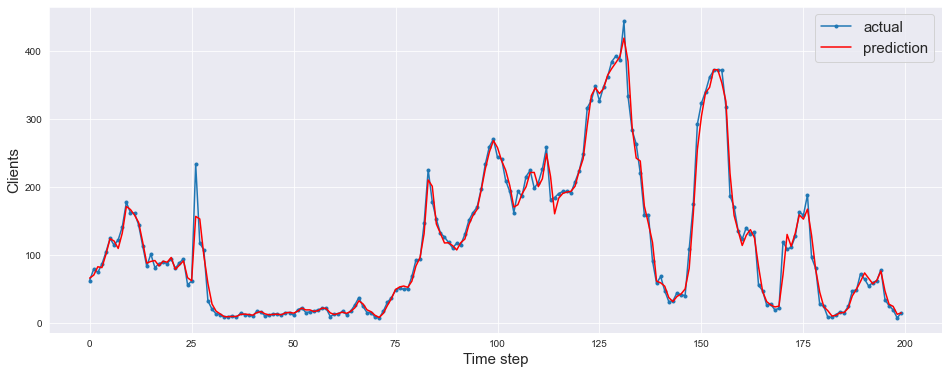

In [76]:
aa=[x for x in range(200)]
plt.plot(aa, (without_na_ts_data.clients[-200:]), marker='.', label="actual")
plt.plot(aa, (y_hat_rf[-200:]), 'r', label="prediction")
plt.ylabel('Clients', size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=15)
plt.show()

In [77]:
without_na_ts_data.loc[:, without_na_ts_data.columns != 'clients']

,hour,month,weekday,last_day_m,clients_l1,clients_l2,clients_l3,clients_l4,clients_l5,clients_l6,...,clients_l45,clients_l46,clients_l47,clients_l48,min48,mean48,max48,min24,mean24,max24
date,,,,,,,,,,,,,,,,,,,,,
2010-01-05 22:00:00,22,1,5,0,106.0,84.0,60.0,59.0,56.0,50.0,...,58.0,79.0,73.0,76.0,53.0,112.395833,181.0,20.0,31.333333,79.0
2010-01-05 23:00:00,23,1,5,0,66.0,106.0,84.0,60.0,59.0,56.0,...,25.0,58.0,79.0,73.0,53.0,111.354167,181.0,20.0,29.291667,58.0
2010-01-06 00:00:00,0,1,6,0,50.0,66.0,106.0,84.0,60.0,59.0,...,26.0,25.0,58.0,79.0,53.0,109.479167,181.0,20.0,28.291667,34.0
2010-01-06 01:00:00,1,1,6,0,56.0,50.0,66.0,106.0,84.0,60.0,...,28.0,26.0,25.0,58.0,25.0,106.687500,181.0,20.0,28.375000,34.0
2010-01-06 02:00:00,2,1,6,0,77.0,56.0,50.0,66.0,106.0,84.0,...,26.0,28.0,26.0,25.0,25.0,103.458333,170.0,20.0,28.333333,34.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2014-12-30 19:00:00,19,12,30,0,79.0,63.0,60.0,55.0,65.0,73.0,...,324.0,293.0,175.0,110.0,32.0,211.520833,444.0,20.0,180.125000,373.0
2014-12-30 20:00:00,20,12,30,0,35.0,79.0,63.0,60.0,55.0,65.0,...,341.0,324.0,293.0,175.0,32.0,212.583333,444.0,20.0,173.250000,373.0
2014-12-30 21:00:00,21,12,30,0,26.0,35.0,79.0,63.0,60.0,55.0,...,362.0,341.0,324.0,293.0,32.0,214.958333,444.0,20.0,166.583333,373.0


In [97]:
def update_sliding(pd_df_in):
    df_temp = pd_df_in.copy()
    df_temp.drop(['min24', 'mean24', 'max24', 'min48', 'mean48', 'max48'], axis='columns', inplace=True)
    clients_val = df_temp[["clients"]]
    width = 24
    shifted = clients_val.shift(width -1)
    window = shifted.rolling(window=width)

    new_df = pd.concat([window.min(), window.mean(), window.max()], axis=1)
    new_df.columns = ['min24', 'mean24', 'max24']


    width=48
    shifted = clients_val.shift(width -1)
    window = shifted.rolling(window=width)

    new_df_2 = pd.concat([window.min(), window.mean(), window.max()], axis=1)
    new_df_2.columns = ['min48', 'mean48', 'max48']

    new_df_2= pd.merge(new_df_2, new_df, how='outer', left_index=True, right_index=True)
    df_temp = pd.merge(df_temp, new_df_2, how='outer', left_index=True, right_index=True)
    
    return df_temp

In [100]:
for_fx = without_na_ts_data.copy()
for_fx = for_fx[-100:]
for_fx = for_fx.append(df_repeated)

generate_lagged_features(for_fx, 'clients', 48)
for_fx = update_sliding(for_fx)


for_fx.tail(25)
# for_fx.columns

,clients,hour,month,weekday,last_day_m,clients_l1,clients_l2,clients_l3,clients_l4,clients_l5,...,clients_l45,clients_l46,clients_l47,clients_l48,min48,mean48,max48,min24,mean24,max24
2014-12-30 23:00:00,16.0,23,12,30,0,8.0,20.0,26.0,35.0,79.0,...,373.0,372.0,362.0,341.0,32.0,222.166667,444.0,20.0,151.791667,373.0
2014-12-31 00:00:00,NaN,0,12,31,1,16.0,8.0,20.0,26.0,35.0,...,372.0,373.0,372.0,362.0,32.0,225.875000,444.0,20.0,140.333333,373.0
2014-12-31 01:00:00,NaN,1,12,31,1,NaN,16.0,8.0,20.0,26.0,...,318.0,372.0,373.0,372.0,32.0,229.750000,444.0,20.0,128.166667,372.0
2014-12-31 02:00:00,NaN,2,12,31,1,NaN,NaN,16.0,8.0,20.0,...,188.0,318.0,372.0,373.0,32.0,233.000000,444.0,20.0,113.833333,318.0
2014-12-31 03:00:00,NaN,3,12,31,1,NaN,NaN,NaN,16.0,8.0,...,171.0,188.0,318.0,372.0,32.0,234.937500,444.0,20.0,101.625000,189.0
2014-12-31 04:00:00,NaN,4,12,31,1,NaN,NaN,NaN,NaN,16.0,...,136.0,171.0,188.0,318.0,32.0,234.708333,444.0,9.0,94.166667,189.0
2014-12-31 05:00:00,NaN,5,12,31,1,NaN,NaN,NaN,NaN,NaN,...,124.0,136.0,171.0,188.0,32.0,233.958333,444.0,9.0,87.416667,189.0
2014-12-31 06:00:00,NaN,6,12,31,1,NaN,NaN,NaN,NaN,NaN,...,141.0,124.0,136.0,171.0,32.0,232.062500,444.0,9.0,82.291667,189.0
2014-12-31 07:00:00,NaN,7,12,31,1,NaN,NaN,NaN,NaN,NaN,...,132.0,141.0,124.0,136.0,32.0,229.250000,444.0,9.0,77.833333,189.0
2014-12-31 08:00:00,NaN,8,12,31,1,NaN,NaN,NaN,NaN,NaN,...,134.0,132.0,141.0,124.0,32.0,228.395833,444.0,9.0,72.625000,189.0


##### сделаем цикл, который обновляет все нужные факторы и делает прогноз, потом выдает прогнозирует на 1 час и продолжает

In [148]:
for i in pd.date_range(start='2014-12-31 00:00:00', end='2014-12-31 23:00:00', periods=24):
    t = pd.DataFrame(for_fx.loc[i, ]).transpose()
    for_fx.loc[i, 'clients'] = rf_reg_opt.predict(t.loc[:, t.columns != 'clients'])[0]
    generate_lagged_features(for_fx, 'clients', 48)
    for_fx = update_sliding(for_fx)
for_fx

,clients,hour,month,weekday,last_day_m,clients_l1,clients_l2,clients_l3,clients_l4,clients_l5,...,clients_l45,clients_l46,clients_l47,clients_l48,min48,mean48,max48,min24,mean24,max24
2014-12-26 20:00:00,244.00,20,12,26,0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-12-26 21:00:00,242.00,21,12,26,0,244.00,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-12-26 22:00:00,210.00,22,12,26,0,242.00,244.00,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-12-26 23:00:00,194.00,23,12,26,0,210.00,242.00,244.00,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-12-27 00:00:00,163.00,0,12,27,0,194.00,210.00,242.00,244.00,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2014-12-31 19:00:00,32.46,19,12,31,1,29.86,23.62,23.44,21.90,20.30,...,164.0,128.0,112.0,109.0,20.0,190.416667,444.0,9.0,63.041667,189.0
2014-12-31 20:00:00,37.54,20,12,31,1,32.46,29.86,23.62,23.44,21.90,...,159.0,164.0,128.0,112.0,20.0,186.270833,444.0,9.0,58.541667,189.0
2014-12-31 21:00:00,47.28,21,12,31,1,37.54,32.46,29.86,23.62,23.44,...,189.0,159.0,164.0,128.0,20.0,182.437500,444.0,8.0,52.041667,189.0
2014-12-31 22:00:00,57.28,22,12,31,1,47.28,37.54,32.46,29.86,23.62,...,97.0,189.0,159.0,164.0,20.0,178.187500,444.0,8.0,46.083333,189.0


<AxesSubplot:>

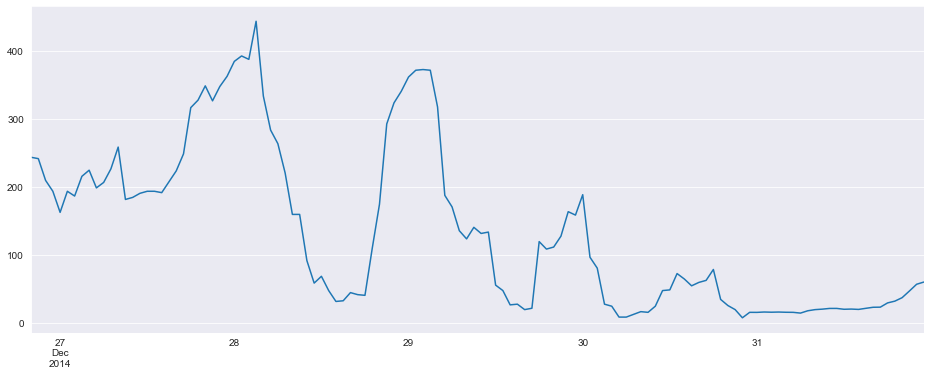

In [138]:
for_fx.clients.plot()

In [146]:
fin_pred_rf = pd.DataFrame(for_fx.clients['2014-12-31 00:00:00':])
fin_pred_rf.columns = ['yhat']
fin_pred_rf['ds'] = fin_pred_rf.index
fin_pred_rf = fin_pred_rf[['ds', 'yhat']]
fin_pred_rf.to_csv('rf_predict.csv', index=False)

fin_pred_rf

,ds,yhat
2014-12-31 00:00:00,2014-12-31 00:00:00,15.94
2014-12-31 01:00:00,2014-12-31 01:00:00,16.46
2014-12-31 02:00:00,2014-12-31 02:00:00,16.18
2014-12-31 03:00:00,2014-12-31 03:00:00,16.42
2014-12-31 04:00:00,2014-12-31 04:00:00,16.10
2014-12-31 05:00:00,2014-12-31 05:00:00,15.98
2014-12-31 06:00:00,2014-12-31 06:00:00,14.88
2014-12-31 07:00:00,2014-12-31 07:00:00,18.28
2014-12-31 08:00:00,2014-12-31 08:00:00,19.98
2014-12-31 09:00:00,2014-12-31 09:00:00,20.68
